fine tuning, mutant 1/2, best_loss=341.55199599404745: 100%|██████████| 6/6 [00:00<00:00, 18.40it/s]


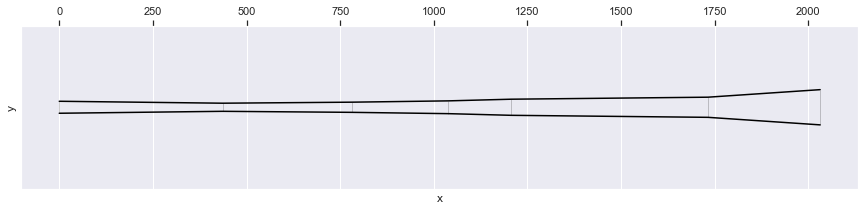

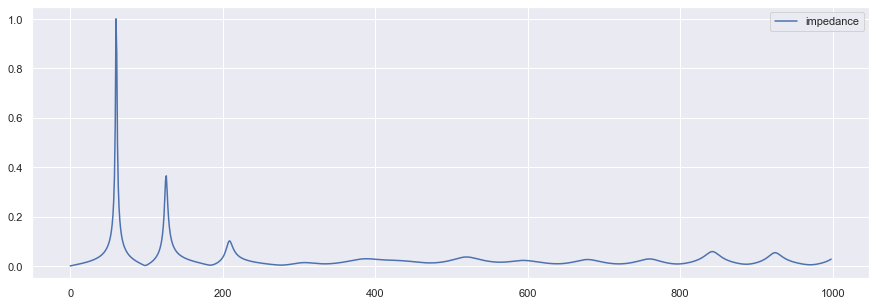

size bell end: 94mm


,t,freq,note,cent-diff,amp
0,0,61,H2,-21,3.474549e+07
1,0,127,H3,48,1.268531e+07
2,0,210,G#3,19,3.549727e+06
3,0,309,D#4,-12,4.960743e+05
4,0,389,G4,-14,1.036133e+06
5,0,521,C5,-8,1.284212e+06
6,0,595,D5,22,8.014973e+05
7,0,680,F5,-47,9.284006e+05
8,0,761,F#5,48,1.008742e+06
9,0,843,G#5,25,2.040490e+06


exploring:   1%|          | 53/6000 [00:13<05:11, 19.06it/s]

In [3]:
from cad.calc.didgmo import PeakFile, didgmo_bridge
from cad.calc.visualization import DidgeVisualizer, FFTVisualiser, visualize_geo_fft
import matplotlib.pyplot as plt
from cad.calc.conv import note_to_freq, note_name, freq_to_note
from cad.calc.geo import Geo
from IPython.display import clear_output
import math
import random
import copy
from tqdm import tqdm
from cad.calc.loss import ScaleLoss, AmpLoss, CombinedLoss
from cad.calc.mutation import *
from cad.calc.parameters import BasicShapeParameters

loss=CombinedLoss(
    [ScaleLoss(scale=[0,3,5,7,10], fundamental=-31, n_peaks=8), AmpLoss(n_peaks=8)],
    [5.0, 0.5]
)

bsp=BasicShapeParameters()

#geo=mutate_explore_then_finetune(loss=loss, parameters=BasicShapeParameters(), n_poolsize=10, n_explore_iterations=3000, n_finetune_iterations=300)
geo=mutate_explore_then_finetune(loss=loss, parameters=BasicShapeParameters(), n_poolsize=2, n_explore_iterations=2, n_finetune_iterations=2)

visualize_geo_fft(geo.make_geo(), None)

In [2]:
loss=CombinedLoss(
    [ScaleLoss(scale=[0,3,5,7,10], fundamental=-31, n_peaks=8), AmpLoss(n_peaks=8)],
    [5.0, 0.5]
)

bsp=BasicShapeParameters()

geo=mutate_explore_then_finetune(loss=loss, parameters=BasicShapeParameters(), n_poolsize=10, n_explore_iterations=3000, n_finetune_iterations=300)
#geo=mutate_explore_then_finetune(loss=loss, parameters=BasicShapeParameters(), n_poolsize=2, n_explore_iterations=2, n_finetune_iterations=2)

visualize_geo_fft(geo.make_geo(), None)

exploring:   1%|          | 53/6000 [00:03<05:11, 19.06it/s]

KeyboardInterrupt: 

In [14]:
class Mutator:
    
    def __init__(self, father, loss, n_iterations, learning_rate=1, n_poolsize=10, decrease_lr=True):
        self.father=father
        self.loss=loss
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.n_poolsize=n_poolsize
        self.pool=[]
        self.decrease_lr=decrease_lr
        
    def mutate(self, pbar=None):
        
        pbar_was_opened= (pbar is None)
        if pbar is None:
            pbar=tqdm(total=self.n_iterations,  position=0, leave=True)
            
        total_loss=0.0

        for i_iteration in range(self.n_iterations):

            lr=self.learning_rate
            if self.decrease_lr:
                lr=lr-(i_iteration*lr/self.n_iterations)

            mutant=self.father.copy()
            mutant.mutate(lr)
            mutant_loss=self.loss.get_loss(mutant.make_geo())
            total_loss += mutant_loss

            if len(self.pool)<self.n_poolsize or mutant_loss < self.pool[-1]["loss"]:
                self.pool.append({
                    "loss": mutant_loss,
                    "mutant": mutant 
                })
                self.pool.sort(key=lambda x : x["loss"])
                if len(self.pool) > self.n_poolsize:
                    self.pool=self.pool[0:self.n_poolsize]

            pbar.update(1)

            average_loss=total_loss / (1+i_iteration)
            best_loss=self.pool[0]["loss"]
            
            if pbar_was_opened:
                pbar.set_description(f"iteration={i_iteration+1}/{self.n_iterations}, best_loss={best_loss:.2f}, average_loss={average_loss:.2f}")
        
        if pbar_was_opened:
            pbar.close()
            
        return self.pool[0]["mutant"], self.pool[0]["loss"]
    
    def get_pool(self):
        return [x["mutant"] for x in self.pool]
    
# mutate first in an exploratory and then in a fine tuning fashion
def mutate_explore_then_finetune(loss=None, parameters=BasicShapeParameters(), n_poolsize=10, n_explore_iterations=3000, n_finetune_iterations=300):
    assert(loss != None)
    mutator=Mutator(parameters, loss, n_explore_iterations, n_poolsize=n_poolsize, decrease_lr=False)
    pbar=tqdm(total=n_explore_iterations + n_poolsize*n_finetune_iterations,  position=0, leave=True)
    pbar.set_description("exploring")
    mutator.mutate(pbar)
    pbar.set_description("fine tuning")
    pool_mutator=PoolMutator(mutator.get_pool(), loss, n_finetune_iterations, 0.1)
    best_geo=pool_mutator.mutate(pbar)
    return best_geo


0 32
605.0971712175648 66.66943352843349
1103.4071588894167 83.54794949510051
1494.9299630155556 104.86664853369035
1730.34453013101 146.95206597941328


In [14]:
from cad.calc.loss import Loss
class ScaleLoss(Loss):
    
    # default: d minor pentatonic with 5 toots
    def __init__(self, scale=[0,3,5,7,10], transpose=-31, n_peaks=5):
        
        self.scale_note_numbers=[]
        for i in range(len(scale)):
            self.scale_note_numbers.append(scale[i]+transpose)
        self.scale_frequencies=[]
        self.n_peaks=n_peaks
        n_octaves=5
        for note_number in self.scale_note_numbers:
            for i in range(n_octaves):
                freq=note_to_freq(note_number+12*i)
                self.scale_frequencies.append(freq)
                
    def get_loss(self, geo, peak=None, fft=None):
        
        if peak == None and fft == None:
            try:
                peak, fft=didgmo_bridge(geo)
            except Exception:
                return 100000.0

        if len(peak.impedance_peaks) < self.n_peaks:
            return 100000.0

        loss=0
        for i in range(self.n_peaks):
            f_peak=peak.impedance_peaks[i]["freq"]
            # get closest key from scale
            f_next_scale=min(self.scale_frequencies, key=lambda x:abs(x-f_peak))

            f_peak=math.log(f_peak, 2)
            f_next_scale=math.log(f_next_scale, 2)
            
            decrease_factor=1-(0.5*i/self.n_peaks)
            loss += 100*decrease_factor*abs(f_peak-f_next_scale)
            
        return loss
    
loss=ScaleLoss(scale=[0,3,5,7,10], transpose=-31, n_peaks=5)
loss=AmpLoss()
loss.get_loss(shape)


0

In [19]:
n_iterations=100
i=99
lr=1

lr-(i*lr/n_iterations)

0.0050000000000000044